# KF Results

### VG Todos
[ ] Discuss and implement goal prediction

[ ] Combine this with LSTM.  Ideally one analysis code agnostic to model choice (use common dict format).

[ ] IMM?  How to fit a CA model when our accel. measurements are not great.

[ ] Loop over all the folds to get final MSE/accuracy mean and std-dev.

[ ] Double check the heading to make sure no large jumps screw up results.

In [1]:
import re
import numpy as np
import unidecode
from keras.preprocessing.sequence import pad_sequences
from IPython import get_ipython;   
#get_ipython().magic('reset -sf')
import pandas
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout,Softmax,Flatten,concatenate
from keras.layers import LSTM
from keras.layers import *
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from IPython.display import Image

import pickle
import glob

# TODO: probably don't need most of these imports, maybe useful if we want to make a single ipynb at the end.
# VG KF imports:
from kf_impl import EKF_CV_MODEL, EKF_CA_MODEL, fix_angle
import pdb

Using TensorFlow backend.


In [2]:
# The function to extract training data from pickles
def extract_data(pklfiles_to_process, file_num, crop=None):
    with open(pklfiles_to_process[file_num], 'rb') as f:
        dataset_all = pickle.load(f)
        
    # All the history trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    history_traj_data = np.array(dataset_all['features'])[:, :, :]

    # All the future trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    future_traj_data = np.array(dataset_all['labels'])[:, :, :-1]

    # All the goal positins and occupancy (x, y, occup), with shape (batch_size, (goal_nums * feature_dims))
    goals_position = np.array(dataset_all['goals'])
    goals_position = goals_position.reshape((goals_position.shape[0], goals_position.shape[1] * goals_position.shape[2]))

    # All intention labels, with shape (batch_size, goal_nums)
    goal_idx = np.array(dataset_all['labels'])[:, 0, -1]
    # Convert to one-hot and the last one is undecided (-1)
    one_hot_goal = to_categorical(goal_idx, num_classes=33)
    
    if crop is not None:
        raise NotImplementedError("TODO")
    
    return history_traj_data, future_traj_data, goals_position, one_hot_goal

In [3]:
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()

print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

train_set = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

test_set  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

# TODO: loop over test set choices to get average result.

# Train Set
for fold in [0,1,2,3]:
    search_str = 'fold_%d' % fold
    search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
    assert(len(search_res) == 1)
    file_num = search_res[0][0]
    print('Fold: ', fold, '; filenum: ', file_num)
    history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process, file_num)
    
    if train_set['history_traj_data'] is None:
        train_set['history_traj_data'] = history_traj_data
        train_set['future_traj_data']  = future_traj_data
        train_set['goal_position']     = goals_position
        train_set['one_hot_goal']      = one_hot_goal         
    else:
        train_set['history_traj_data'] = np.append(train_set['history_traj_data'], history_traj_data, axis=0)
        train_set['future_traj_data']  = np.append(train_set['future_traj_data'], future_traj_data, axis=0)
        train_set['goal_position']     = np.append(train_set['goal_position'], goals_position, axis=0)
        train_set['one_hot_goal']      = np.append(train_set['one_hot_goal'], one_hot_goal, axis=0)
          
# Test Set
for fold in [4]:
    search_str = 'fold_%d' % fold
    search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
    assert(len(search_res) == 1)
    file_num = search_res[0][0]
    print('Fold: ', fold, '; filenum: ', file_num)
    history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process, file_num)

    if test_set['history_traj_data'] is None:
        test_set['history_traj_data'] = history_traj_data
        test_set['future_traj_data']  = future_traj_data
        test_set['goal_position']     = goals_position
        test_set['one_hot_goal']      = one_hot_goal         
    else:
        test_set['history_traj_data'] = np.append(test_set['history_traj_data'], history_traj_data, axis=0)
        test_set['future_traj_data']  = np.append(test_set['future_traj_data'], future_traj_data, axis=0)
        test_set['goal_position']     = np.append(test_set['goal_position'], goals_position, axis=0)
        test_set['one_hot_goal']      = np.append(test_set['one_hot_goal'], one_hot_goal, axis=0)

Found 6 pkl files: ['./dataset/pilot_dataset_11_30_18:58:10.pkl', './dataset/pilot_dataset_11_30_18:58:10_fold_0.pkl', './dataset/pilot_dataset_11_30_18:58:10_fold_1.pkl', './dataset/pilot_dataset_11_30_18:58:10_fold_2.pkl', './dataset/pilot_dataset_11_30_18:58:10_fold_3.pkl', './dataset/pilot_dataset_11_30_18:58:10_fold_4.pkl']
Fold:  0 ; filenum:  1
Fold:  1 ; filenum:  2
Fold:  2 ; filenum:  3
Fold:  3 ; filenum:  4
Fold:  4 ; filenum:  5


In [4]:
print('Training: ')
print([(k, v.shape) for k,v in train_set.items()])

print('Testing: ')
print([(k, v.shape) for k,v in test_set.items()])

Training: 
[('history_traj_data', (1411, 5, 5)), ('future_traj_data', (1411, 20, 5)), ('goal_position', (1411, 96)), ('one_hot_goal', (1411, 33))]
Testing: 
[('history_traj_data', (352, 5, 5)), ('future_traj_data', (352, 20, 5)), ('goal_position', (352, 96)), ('one_hot_goal', (352, 33))]


In [5]:
# Step 1: Using EKF with constant velocity assumption for now.  First estimate disturbance covariance from data.
    
# Compute residuals and then fit Q:
N_train = train_set['history_traj_data'].shape[0]
N_steps = train_set['history_traj_data'].shape[1] + train_set['future_traj_data'].shape[1] - 1
N_Q_fit = N_train * N_steps
nx = train_set['history_traj_data'].shape[2]
Q_est = np.zeros((nx, nx))

for i in range(N_train):
    traj_full = np.concatenate((train_set['history_traj_data'][i], \
                                train_set['future_traj_data'][i]), \
                                axis = 0)
    for j in range(1, traj_full.shape[0] - 1):
        x_curr = traj_full[j-1]
        x_next = traj_full[j]
        x_next_model = EKF_CV_MODEL._f_cv(x_curr, dt=0.1) # TODO: maybe better to get dt from pkl
        w = x_next - x_next_model
        w[2] = fix_angle(w[2])
        Q_est += 1./N_Q_fit * np.outer(w,w)

np.set_printoptions(precision=6)        
print(Q_est)

kf = EKF_CV_MODEL(Q=Q_est, R = np.diag([1e-3]*3), dt = 0.1)

[[ 6.014892e-04  3.116137e-05 -2.968488e-05 -3.874785e-05  6.816154e-05]
 [ 3.116137e-05  1.372681e-03 -7.770560e-06 -7.825178e-04 -2.553509e-05]
 [-2.968488e-05 -7.770560e-06  2.275290e-03 -3.481568e-06  2.157181e-05]
 [-3.874785e-05 -7.825178e-04 -3.481568e-06  1.661219e-02  1.298382e-04]
 [ 6.816154e-05 -2.553509e-05  2.157181e-05  1.298382e-04  4.392536e-04]]


In [6]:
# Step 2: Make trajectory predictions and then intent predictions.
# TODO: move repeated code to kf_impl.
def make_kf_prediction(kf, x_hist, N_pred):
    # First init the KF with x_hist[0] for pose only.
    kf.x = x_hist[0,:]
    kf.x[3:] = 0. # velocity unknown, set to 0. WLOG
    kf.P = np.eye(5) # may adjust this to be state dependent

    for i in range(1, x_hist.shape[0]):
        kf.predict()
        kf.update(x_hist[i,:3]) # only pose
        
    # Then run predict for N_pred steps
    x_pred = []; P_pred = []
    for i in range(N_pred):
        kf.predict()
        x_pred.append(kf.get_x())
        P_pred.append(kf.get_P())
    
    return np.array(x_pred), np.array(P_pred) # N_pred by nx and N_pred by nx by nx

def estimate_intent_from_trajectory(traj_hist, traj_future_pred, goals):
    '''TODO: discuss this in more depth'''
    # Basic idea: find min_dist to goal from predicted trajectory
    # Assume we proceed to the closest, unoccupied goal with higher 
    # probability so use softmax over min_dist for unoccupied spots.
    # To account for undetermined intent, 
    # so use softmax 
    
N_pred = train_set['future_traj_data'].shape[1]
nx = train_set['future_traj_data'].shape[2]

train_set['future_traj_pred'] = None
for i in range(N_train):
    x_pred, P_pred = make_kf_prediction(kf, train_set['history_traj_data'][i], N_pred)
    x_pred = x_pred.reshape(1, N_pred, nx)
    # P_pred mostly unused for now.  It grows really fast, almost like a full reach set.
    
    if train_set['future_traj_pred'] is None:
        train_set['future_traj_pred'] = x_pred   
    else:
        train_set['future_traj_pred'] = np.append(train_set['future_traj_pred'], x_pred, axis=0)
    
N_test = test_set['history_traj_data'].shape[0]
test_set['future_traj_pred'] = None
for i in range(N_test):
    x_pred, P_pred = make_kf_prediction(kf, test_set['history_traj_data'][i], N_pred)
    x_pred = x_pred.reshape(1, N_pred, nx)
    
    if test_set['future_traj_pred'] is None:
        test_set['future_traj_pred'] = x_pred       
    else:
        test_set['future_traj_pred'] = np.append(test_set['future_traj_pred'], x_pred, axis=0)

print('Train Data: ', train_set['future_traj_data'].shape, '; Train Pred: ',  train_set['future_traj_pred'].shape)
print('Test Data: ', test_set['future_traj_data'].shape, '; Test Pred: ',  test_set['future_traj_pred'].shape)

Train Data:  (1411, 20, 5) ; Train Pred:  (1411, 20, 5)
Test Data:  (352, 20, 5) ; Test Pred:  (352, 20, 5)


In [11]:
# Step 3: Get overall MSE following in position (NOT POSE)!  Should find a common implementation of this in future.
def get_mse(future_traj_pred, future_traj_label):
    N = future_traj_pred.shape[0]
    print(N)
    mse = 0.
    for i in range(N):
        se = np.sum(np.square(future_traj_pred[i,:2] - future_traj_label[i,:2]))
        mse += se / N
    return mse
        
train_mse = get_mse(train_set['future_traj_pred'], train_set['future_traj_data'])
test_mse = get_mse(test_set['future_traj_pred'], test_set['future_traj_data'])

print(train_mse, test_mse)
# Seems a bit off to me, is the division by N done correctly?

1411
352
0.23572808379454877 2.139044813653149


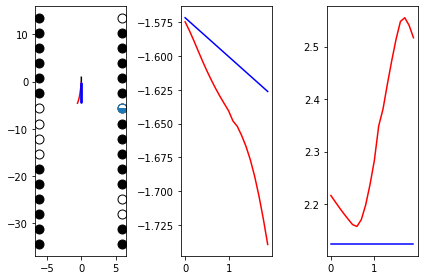

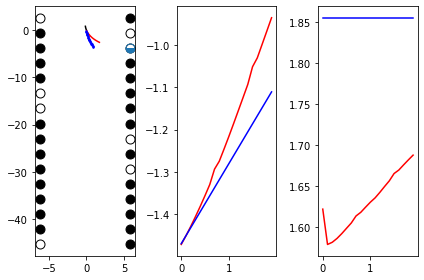

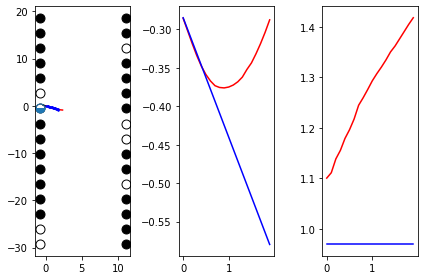

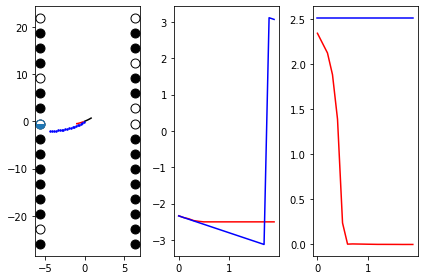

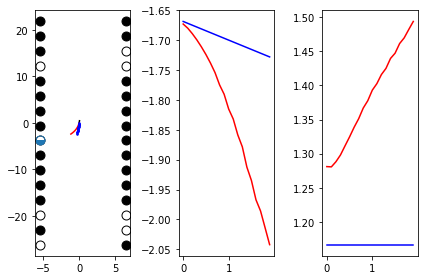

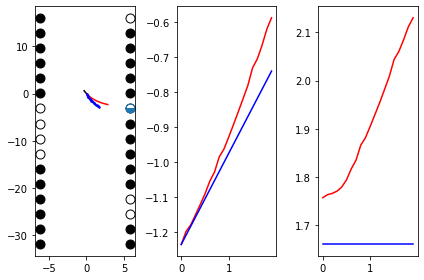

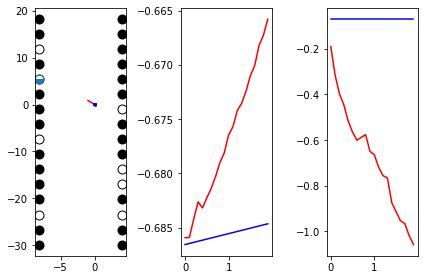

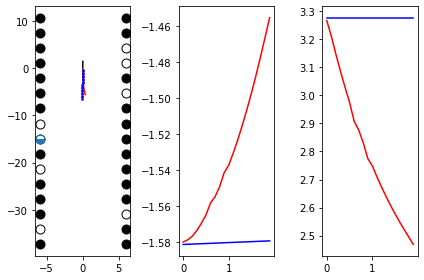

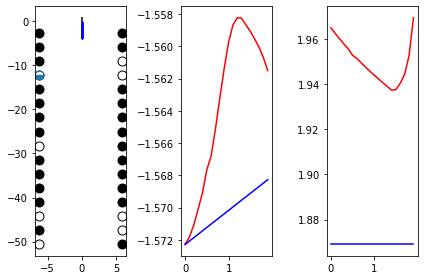

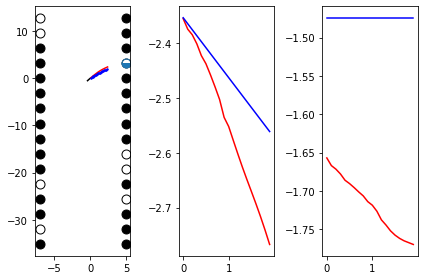

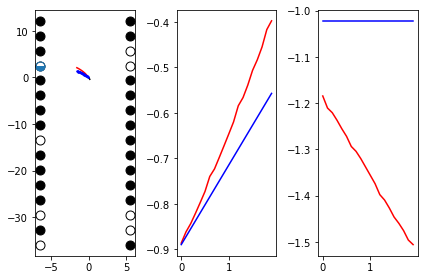

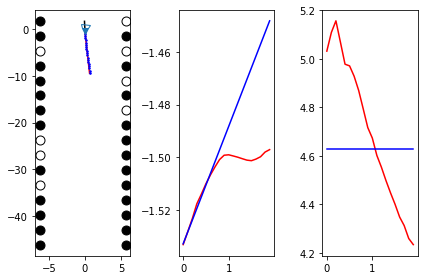

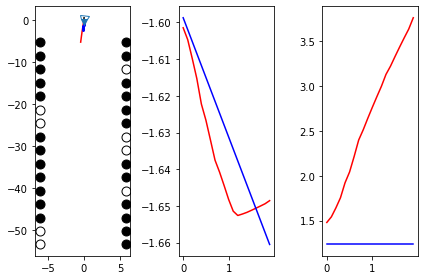

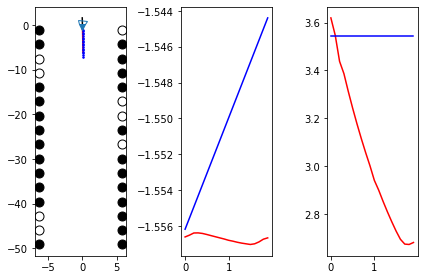

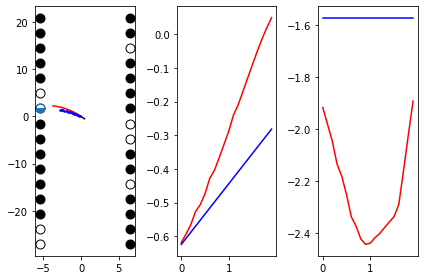

In [14]:
# Step 4: Plotting trajectory prediction results via Xu's script.  Can also overlay goal here in a single plot.
for ind_sample in range(0, N_train, 100):
    x_hist_s     = train_set['history_traj_data'][ind_sample]
    x_label_s    = train_set['future_traj_data'][ind_sample]
    x_pred_s     = train_set['future_traj_pred'][ind_sample]
    goals_s      = train_set['goal_position'].reshape(N_train, 32, 3)[ind_sample]
    goal_label_s = train_set['one_hot_goal'][ind_sample]


    plt.figure()

    plt.subplot(131)
    # Plot the vehicle trajectory in the snippet
    plt.plot(x_hist_s[:,0], x_hist_s[:,1], 'k')
    plt.plot(x_label_s[:,0], x_label_s[:,1], 'r')
    plt.plot(x_pred_s[:,0], x_pred_s[:,1], 'b.', markersize = 3)

    # Plot the occupancy in the snippet
    for goal in goals_s:
        if goal[2] > 0:
            plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
        else:
            plt.plot(goal[0], goal[1], 'ko', markersize = 9)

    # Get the ground truth intention
    gt_idx = np.argmax(goal_label_s)
    if gt_idx == 32: # If it is "-1" -> undetermined 
        plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    else:
        plt.plot(goals_s[gt_idx][0], goals_s[gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)

    plt.subplot(132)
    plt.plot(np.arange(N_pred) * 0.1, x_label_s[:,2], 'r')
    plt.plot(np.arange(N_pred) * 0.1, x_pred_s[:,2], 'b')
    
    plt.subplot(133)
    plt.plot(np.arange(N_pred) * 0.1, x_label_s[:,3], 'r')
    plt.plot(np.arange(N_pred) * 0.1, x_pred_s[:,3], 'b')
    
    plt.tight_layout()


In [ ]:
'''
# Plot the result
goal_ind = np.arange(33)
bar_width = 0.35
# Recover the goal coordinates
test_goals_coords = test_goals_position.reshape((test_goals_position.shape[0], 32, 3))

for i in range(0, len(goal_pred), 10):
    plt.figure()
    plt.subplot(121)
    
    # Plot the vehicle trajectory in the snippet
    plt.plot(test_hist_traj[i][:,0], test_hist_traj[i][:,1], 'k')
    plt.plot(test_future_traj[i][:,0], test_future_traj[i][:,1], 'r')
    
    # Plot the occupancy in the snippet
    for goal in test_goals_coords[i]:
        if goal[2] > 0:
            plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
        else:
            plt.plot(goal[0], goal[1], 'ko', markersize = 9)
    
    # Get the ground truth intention
    gt_idx = np.argmax(test_one_hot_goal[i])
    # Predictions above a threshold
    thres = 1e-2
    best_k_idx = [k for k, p in enumerate(goal_pred[i]) if p >= thres]
    if gt_idx == 32: # If it is "-1" -> undetermined 
        plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    else:
        plt.plot(test_goals_coords[i][gt_idx][0], test_goals_coords[i][gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    
    for j in best_k_idx:
        if j == 32:
            plt.plot(0, 0, 'v', fillstyle='none', color = '#ff770e', markersize = 9)
        else:
            plt.plot(test_goals_coords[i][j][0], test_goals_coords[i][j][1], 'o', fillstyle='none', color = '#ff770e', markersize = 9)
            
    plt.title('Dataset Entry %d' % i)
    
    plt.subplot(122)
    p1 = plt.bar(goal_ind - bar_width/2, test_one_hot_goal[i], bar_width, label='GT')
    p2 = plt.bar(goal_ind + bar_width/2, goal_pred[i], bar_width, label='Pred')
    plt.xlabel('Goal Index')
    plt.ylabel('Probability')
    plt.title('Likelihood from Dataset Entry %d' % i)
    plt.legend()
    plt.tight_layout()
    '''